In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../..")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from librep.datasets.har.loaders import (
    MotionSense_BalancedView20HZ
)

2022-11-29 11:07:05.972876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 11:07:06.198288: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-29 11:07:06.198329: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-29 11:07:07.476471: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [5]:
from librep.transforms.topo_ae import (
    TopologicalDimensionalityReduction,
    CustomTopoDimRedTransform
)
from librep.transforms import UMAP
from sklearn.manifold import TSNE
from experiments.Topological_ae.Experiment_utils import *
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

## Reading model

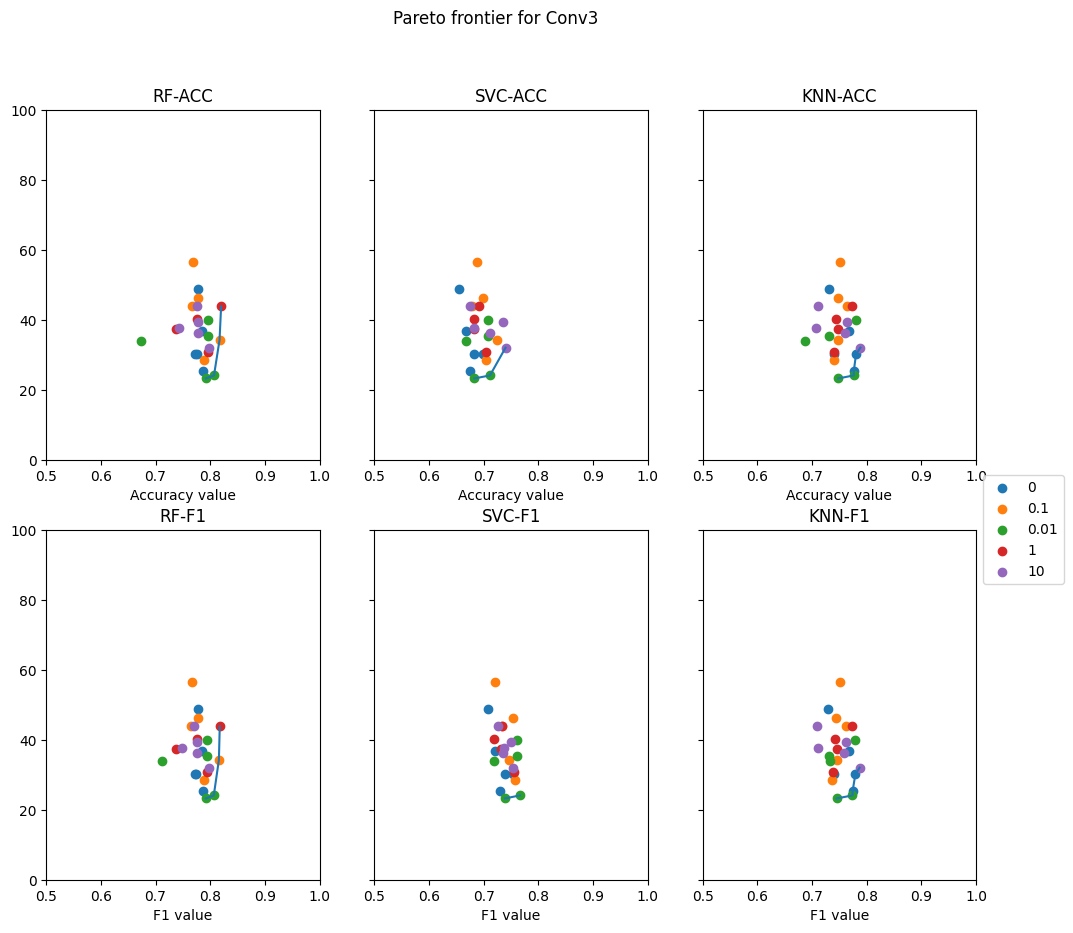

In [10]:
import pickle
import matplotlib.pyplot as plt
# Variables to reuse
save_ids = range(5)
model_name = 'ConvolutionalAutoencoder_custom_dim3'
model_dim = 10
model_epc = 500
model_lams = [0, 0.1, 0.01, 1, 10]

all_rf_acc = []
all_rf_f1 = []
all_svc_acc = []
all_svc_f1 = []
all_knn_acc = []
all_knn_f1 = []
all_y = []
f, axs = plt.subplots(2, 3, sharey=True, figsize=(12, 10))
f.suptitle('Pareto frontier for Conv3')

for model_lam in model_lams:
    rf_acc = []
    rf_f1 = []
    svc_acc = []
    svc_f1 = []
    knn_acc = []
    knn_f1 = []
    recon_error = []
    for save_id in save_ids:
        filename = 'data/{}_{}_{}_{}_{}.pkl'.format(model_name, model_lam, model_dim, model_epc, save_id)
        filehandler = open(filename, 'rb')
        model = pickle.load(filehandler)
        filehandler.close()
        recon_error.append(model.train_recon_error[-1])
        all_y.append(model.train_recon_error[-1])
        # print(model.train_recon_error[-1])
        filename = 'data/{}_{}_{}_{}_{}.acc_f1.pkl'.format(model_name, model_lam, model_dim, model_epc, save_id)
        filehandler = open(filename, 'rb')
        evaluation = pickle.load(filehandler)
        filehandler.close()
        rf_acc.append(evaluation['RF-ACC'])
        all_rf_acc.append(evaluation['RF-ACC'])
        rf_f1.append(evaluation['RF-F1'])
        all_rf_f1.append(evaluation['RF-F1'])
        svc_acc.append(evaluation['SVC-ACC'])
        all_svc_acc.append(evaluation['SVC-ACC'])
        svc_f1.append(evaluation['SVC-F1'])
        all_svc_f1.append(evaluation['SVC-F1'])
        knn_acc.append(evaluation['KNN-ACC'])
        all_knn_acc.append(evaluation['KNN-ACC'])
        knn_f1.append(evaluation['KNN-F1'])
        all_knn_f1.append(evaluation['KNN-F1'])
    axs[0, 0].set_title('RF-ACC')
    
    axs[0, 0].scatter(rf_acc, recon_error, label=str(model_lam))
    axs[1, 0].set_title('RF-F1')
    # axs[1, 0].set_xlim((0, 1))
    axs[1, 0].scatter(rf_f1, recon_error, label=str(model_lam))
    axs[0, 1].set_title('SVC-ACC')
    # axs[0, 1].set_xlim((0, 1))
    axs[0, 1].scatter(svc_acc, recon_error, label=str(model_lam))
    axs[1, 1].set_title('SVC-F1')
    # axs[1, 1].set_xlim((0, 1))
    axs[1, 1].scatter(svc_f1, recon_error, label=str(model_lam))
    axs[0, 2].set_title('KNN-ACC')
    # axs[0, 2].set_xlim((0, 1))
    axs[0, 2].scatter(knn_acc, recon_error, label=str(model_lam))
    axs[1, 2].set_title('KNN-F1')
    # axs[1, 2].set_xlim((0, 1))
    axs[1, 2].scatter(knn_f1, recon_error, label=str(model_lam))

    axs[1, 2].legend(loc='center left', bbox_to_anchor=(1, 1))

plot_data = [
    {
        'axs_x': 0,
        'axs_y': 0,
        'title': 'RF-ACC',
        'Xs': all_rf_acc
    },
    {
        'axs_x': 1,
        'axs_y': 0,
        'title': 'RF-F1',
        'Xs': all_rf_f1
    },
    {
        'axs_x': 0,
        'axs_y': 1,
        'title': 'SVC-ACC',
        'Xs': all_svc_acc
    },
    {
        'axs_x': 1,
        'axs_y': 1,
        'title': 'SVC-F1',
        'Xs': all_svc_f1
    },
    {
        'axs_x': 0,
        'axs_y': 2,
        'title': 'KNN-ACC',
        'Xs': all_knn_acc
    },
    {
        'axs_x': 1,
        'axs_y': 2,
        'title': 'KNN-F1',
        'Xs': all_knn_f1
    }
]
for p_data in plot_data:
    maxX = True
    maxY = False
    Xs = p_data['Xs']
    Ys = all_y
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)

    '''Plotting process'''
    # plt.scatter(Xs,Ys)
    pf_X = [pair[0] for pair in pareto_front]
    pf_Y = [pair[1] for pair in pareto_front]
    axs[p_data['axs_x'], p_data['axs_y']].plot(pf_X, pf_Y)
    axs[p_data['axs_x'], p_data['axs_y']].set_ylim((0, 100))
    axs[p_data['axs_x'], p_data['axs_y']].set_xlim((0.5, 1))
    if p_data['axs_x'] == 0:
        axs[p_data['axs_x'], p_data['axs_y']].set_xlabel('Accuracy value')
    else:
        axs[p_data['axs_x'], p_data['axs_y']].set_xlabel('F1 value')
    # print(pf_X, pf_Y)
    # plt.show()